# GMM Classification Experiments

We experiment with 2D logistic models.

In [ ]:
%load_ext autoreload
%autoreload 2


import torch
from torch import nn
from torch import optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from copy import deepcopy
from typing import List
import matplotlib.pyplot as plt
from layered_unlearning.utils import set_seed
from layered_unlearning.gmm_classification import (
    GaussianMixture,
    Gaussian,
    LogisticModel,
)

seed = set_seed(0)

## Scripts
Below are scripts for training and evaluating our models. Relearning is included in the training script.

In [ ]:
def evaluate(
    model: nn.Module,
    X: torch.Tensor,
    y: torch.Tensor,
    device: str = "cuda",
    n_classes: int = 2,
):
    """
    Calculate accuracy for each class in the dataset.
    """
    # Convert data to PyTorch tensors
    X = X.to(device)
    y = y.to(device)

    model.eval()
    accuracies = []
    with torch.no_grad():
        outputs = model(X)
        outputs = (outputs > 0.5).float()
        # Calculate accuracy for each class
        for i in range(n_classes):
            class_mask = y == i
            class_accuracy = (
                (outputs[class_mask] == y[class_mask]).float().mean().item()
            )
            accuracies.append(class_accuracy)
    return accuracies


def train(
    model: nn.Module,
    X: torch.Tensor,
    y: torch.Tensor,
    flip_mask: torch.Tensor,
    mask: torch.Tensor = None,
    n_epochs: int = 1,
    lr: float = 0.01,
    batch_size: int = 32,
    weight_decay: float = 0.01,
    device: str = "cuda",
    eps: float = 1e-8,
    log_1_minus_p: bool = False,
):
    """
    Train the model using the given data and parameters.
    log_1_minus_p: if True, we optimize log(1 - p), otherwise we do gradient ascent.
    flip_mask: mask for the data points we want to flip in terms of leanr/unlearn.
    mask: mask for the data points we want to use for training, used for relearning.
    """
    # Convert data to PyTorch tensors
    X = X.to(device)
    y = y.to(device)
    flip_mask = flip_mask.to(device)

    X_train = X
    y_train = y

    if mask is not None:
        X_train = X_train[mask]
        y_train = y_train[mask]

        flip_mask = flip_mask[mask]

    # Define loss function and optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    dataloader = DataLoader(
        list(zip(X_train, y_train, flip_mask)),
        batch_size=batch_size,
        shuffle=True,
    )

    for epoch in range(n_epochs):
        model.train()
        for batch_X, batch_y, batch_flip_mask in (
            pbar := tqdm(dataloader, desc=f"Epoch {epoch + 1}/{n_epochs}")
        ):
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            batch_y = batch_y.float()

            if log_1_minus_p:
                # do 1 - p
                outputs = torch.where(
                    batch_flip_mask,
                    1 - outputs,
                    outputs,
                )

            loss = -(
                batch_y * torch.log(outputs + eps)
                + (1 - batch_y) * torch.log(1 - outputs + eps)
            )

            if not log_1_minus_p:
                # gradient ascent
                loss = torch.where(
                    batch_flip_mask,
                    -loss,
                    loss,
                )

            loss = loss.mean()
            loss.backward()
            optimizer.step()
            pbar.set_postfix(
                {
                    "loss": loss.item(),
                }
            )

    return model

## Hyperparameters
Default hyperparameters for our experiments. Of note, we do this in 2 dimensions. 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 2
lr = 1e-2
batch_size = 32
n_classes = 2
n_samples = 5000
dim = 2
weight_decay = 1e-3
quadratic_features = False
eps = 1e-8
log_1_minus_p = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = [
    GaussianMixture(
        classes=[
            Gaussian(mu=torch.tensor([-4, 0]), cov=torch.eye(dim)),
            Gaussian(mu=torch.tensor([-2, 0]), cov=torch.eye(dim)),
        ],
        weights=[0.5, 0.5],
    ),
    GaussianMixture(
        classes=[
            Gaussian(mu=torch.tensor([2, 0]), cov=torch.eye(dim)),
            Gaussian(mu=torch.tensor([4, 0]), cov=torch.eye(dim)),
        ],
        weights=[0.5, 0.5],
    ),
]

assert (
    len(classes) == n_classes
), "Number of classes must match the number of classes in the model"

X = [classes[i].sample(n_samples) for i in range(n_classes)]
y = [torch.tensor([i] * n_samples) for i in range(n_classes)]

X = torch.cat(X, dim=0).float()
y = torch.cat(y, dim=0)

## Training
We train the initial model, the base unlearned model, and the Layered Unlearning (LU) version of the base unlearned model. 

In [4]:
model_checkpoints = {}
evals = {}


def get_model(old_model: nn.Module = None):
    model = LogisticModel(
        dim=dim,
        n_classes=n_classes,
        quadratic_features=quadratic_features,
    ).to(device)
    if old_model is not None:
        model.load_state_dict(old_model.state_dict())
    return model


def global_train(model: nn.Module, learn_A: bool, learn_B: bool, relearn: bool = False):
    y_train = y.clone()

    mask_A = y_train == 0
    mask_B = y_train == 1

    flip_mask = torch.zeros_like(y_train, dtype=torch.bool)
    # if not learning, then flip labels
    if not learn_A:
        flip_mask = flip_mask | mask_A
    if not learn_B:
        flip_mask = flip_mask | mask_B

    # if relearning, then only do labels where things True
    if relearn:
        mask = torch.zeros_like(y_train, dtype=torch.bool)

        if learn_A:
            mask = mask | mask_A
        if learn_B:
            mask = mask | mask_B
    else:
        mask = torch.ones_like(y_train, dtype=torch.bool)

    model = train(
        model,
        X,
        y_train,
        mask=mask,
        flip_mask=flip_mask,
        log_1_minus_p=log_1_minus_p,
        eps=eps,
        n_epochs=n_epochs,
        lr=lr,
        batch_size=batch_size,
        weight_decay=weight_decay,
        device=device,
    )
    return model


def global_eval(model: nn.Module):
    return evaluate(
        model,
        X,
        y,
        device=device,
        n_classes=n_classes,
    )


def visualize(
    name: str,
    X: torch.Tensor,
    y: torch.Tensor,
    n_grid: int = 100,
    n_samples: int = None,
):
    model = model_checkpoints[name]
    model.eval()
    if n_samples is not None:
        if n_samples > X.size(0):
            n_samples = X.size(0)
        inds = torch.randperm(X.size(0))[:n_samples]
        X = X[inds]
        y = y[inds]
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = torch.meshgrid(
        torch.linspace(x_min, x_max, n_grid),
        torch.linspace(y_min, y_max, n_grid),
    )
    grid = torch.stack([xx.ravel(), yy.ravel()], dim=1).to(device)
    with torch.no_grad():
        grid_out = model(grid).squeeze().cpu()

    plt.figure(figsize=(8, 6))
    plt.contourf(
        xx.cpu(),
        yy.cpu(),
        grid_out.reshape(xx.shape),
        levels=[0, 0.5, 1],
        alpha=0.2,
        cmap="coolwarm",
    )

    # scatter each class
    for i in range(n_classes):
        plt.scatter(
            X[y == i, 0].cpu(),
            X[y == i, 1].cpu(),
            label=f"Class {i}",
            alpha=0.6,
            edgecolors="k",
            color="red" if i == 1 else "blue",
        )
    bias = model.linear.bias.detach()
    weights = model.linear.weight.detach()
    # plot decision boundary

    x1 = torch.linspace(x_min, x_max, n_grid).to(device).detach()
    x2 = (-(weights[0, 0] * x1 + bias) / weights[0, 1]).to(device).detach()
    print(f"Weights: {weights.cpu().numpy()}, Bias: {bias.cpu().numpy()}")

    plt.plot(
        x1.cpu(), x2.cpu(), color="black", linestyle="--", label="Decision Boundary"
    )

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.legend()
    plt.show()


def run(start: str, end: str, learn_A: bool, learn_B: bool, relearn: bool = False):
    assert start is None or start in model_checkpoints
    model = get_model(model_checkpoints.get(start))
    model = global_train(model, learn_A=learn_A, learn_B=learn_B, relearn=relearn)
    evals[end] = global_eval(model)
    print(end, evals[end])
    model_checkpoints[end] = deepcopy(model)


def run_relearn(name: str):
    run(name, f"{name}-A", learn_A=True, learn_B=False, relearn=True)
    run(name, f"{name}-B", learn_A=False, learn_B=True, relearn=True)


run(None, "init", learn_A=True, learn_B=True)
run("init", "base", learn_A=False, learn_B=False)
run("init", "base-lu-partial", learn_A=False, learn_B=True)
run("base-lu-partial", "base-lu", learn_A=False, learn_B=False)
run_relearn("base")
run_relearn("base-lu")

Epoch 2/2: 100%|██████████| 313/313 [00:00<00:00, 471.32it/s, loss=0.0152] 


init [0.9850000143051147, 0.9905999898910522]


Epoch 2/2: 100%|██████████| 313/313 [00:00<00:00, 399.91it/s, loss=0.137] 


base [0.015599999576807022, 0.009200000204145908]


Epoch 2/2: 100%|██████████| 313/313 [00:00<00:00, 342.98it/s, loss=0.0487]


base-lu-partial [0.0, 1.0]


Epoch 2/2: 100%|██████████| 313/313 [00:00<00:00, 406.09it/s, loss=0.0531] 


base-lu [0.004799999762326479, 0.02579999901354313]


Epoch 2/2: 100%|██████████| 157/157 [00:00<00:00, 395.09it/s, loss=0.0832]


base-A [1.0, 0.47360000014305115]


Epoch 2/2: 100%|██████████| 157/157 [00:00<00:00, 451.40it/s, loss=0.0734]


base-B [0.5105999708175659, 1.0]


Epoch 2/2: 100%|██████████| 157/157 [00:00<00:00, 370.46it/s, loss=0.127]


base-lu-A [1.0, 0.025599999353289604]


Epoch 2/2: 100%|██████████| 157/157 [00:00<00:00, 374.87it/s, loss=0.0811]


base-lu-B [0.0, 1.0]


## Visualizations
We visualize decision boundaries learned and the resulting model.

/mnt/align4_drive/tcqian/layered-unlearning/venv/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Weights: [[-8.7733680e-01 -1.7904336e-04]], Bias: [-0.01507458]


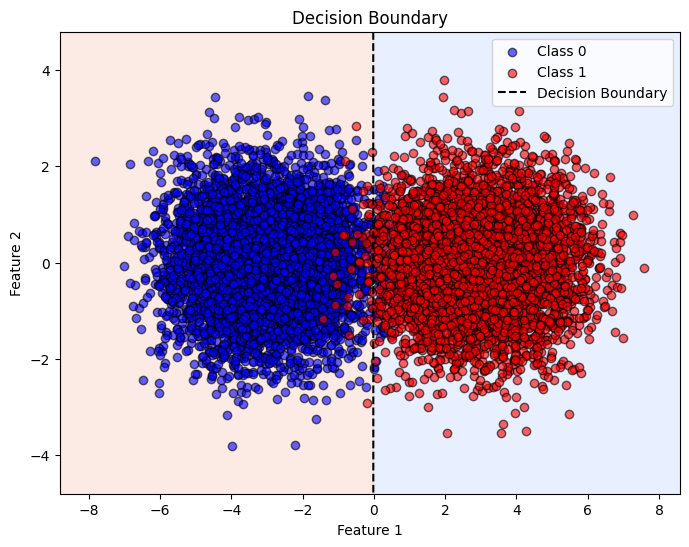

In [5]:
visualize("base", X, y)

Weights: [[-1.7785853e+00  1.2855111e-03]], Bias: [0.65959495]


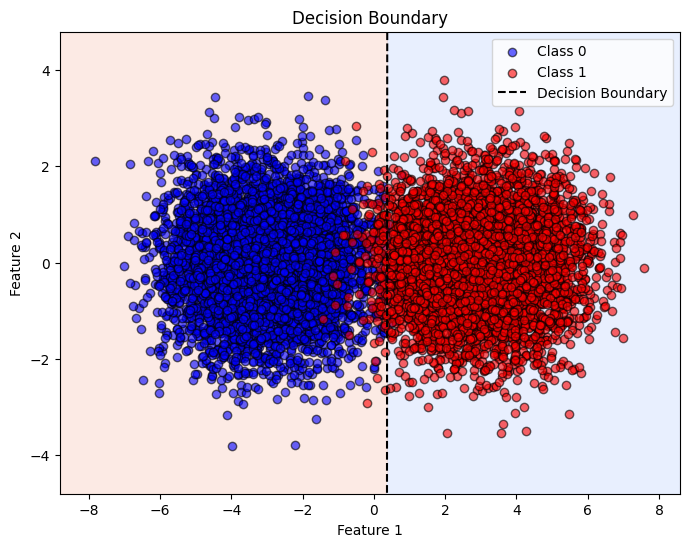

In [6]:
visualize("base-lu", X, y)